## Check GPU states

In [25]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 10.5 GB  | Proc size: 3.4 GB
GPU RAM Free: 6074MB | Used: 9005MB | Util  60% | Total 15079MB


In [26]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

In [0]:
# obtain data
from torchvision import datasets, transforms

## Download datasets

In [0]:
PATH_TRAIN_IM = "/content/train_im/"
PATH_TRAIN_LD = "/content/train_ld/dataset_landmasks_auto_5600/"
PATH_VALID_IM = "/content/valid_im/dataset_valid/"
PATH_VALID_LD = "/content/valid_ld/dataset_landmasks_valid/"
PATH_CSV = "/content/csv/csv/"


In [0]:
PATH_TRAIN = "/content/t_im/dataset_train"
PATH_VALID = "/content/train_im"

In [30]:
def download_and_unzip(filename, target_folder="dataset") -> str:
    if filename[-4:] != ".zip": filename += ".zip"
    url = "http://yucanwu.com/aps360/" + filename

    !cd /content/
    !rm -rf unzip_temp
    !mkdir -p unzip_temp
    !wget $url
    !unzip -qq $filename -d unzip_temp/
    !rm -rf $target_folder
    !mkdir -p $target_folder
    !mv unzip_temp/* $target_folder

    return "/content/" + target_folder + "/"

!rm -rf /content/*
PATH_TRAIN_IM = download_and_unzip("set_a_5600", "train_im")
#PATH_TRAIN_LD = download_and_unzip("set_al_5600", "train_ld") + "dataset_landmasks_auto_5600/"

#PATH_VALID_IM = download_and_unzip("set_v_3500", "valid_im") + "dataset_valid/"
#PATH_VALID_LD = download_and_unzip("set_vl_3500", "valid_ld") + "dataset_landmasks_valid/"

# PATH_SMALL_IM = download_and_unzip("set_a_35", "small_im")
# PATH_SMALL_LD = download_and_unzip("set_al_35", "small_ld") + "dataset_landmasks_auto_35/"

# PATH_T_IM = download_and_unzip("set_t_283901", "t_im")
PATH_T_IM = download_and_unzip("set_t_358514", "t_im") + "dataset_train"
#PATH_T_LD = download_and_unzip("set_tl_283901", "t_ld") + "dataset_landmasks_train/"
#PATH_EXTRA_IM = download_and_unzip("set_t_358514", "t_im") + "dataset_train"
#PATH_EXTRA_LD = download_and_unzip("set_tl_358514", "t_ld") + "dataset_landmasks_train/"

# PATH_A_IM = download_and_unzip("set_a_460382", "a_im") + "Organized"
# PATH_A_LD = download_and_unzip("set_al_460382", "a_ld") + "dataset_landmasks_auto/"
#PATH_A_IM = download_and_unzip("set_a_460382", "a_im")
#PATH_A_LD = download_and_unzip("set_al_460382", "a_ld") + "dataset_landmasks_auto/"

#PATH_CSV = download_and_unzip("csv.zip", "csv") + "csv/"

!rm *.zip


--2020-03-30 20:17:45--  http://yucanwu.com/aps360/set_a_5600.zip
Resolving yucanwu.com (yucanwu.com)... 207.148.19.24
Connecting to yucanwu.com (yucanwu.com)|207.148.19.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92874999 (89M) [application/zip]
Saving to: ‘set_a_5600.zip’

set_a_5600.zip      100%[===================>]  88.57M  12.5MB/s    in 8.7s    

2020-03-30 20:17:55 (10.2 MB/s) - ‘set_a_5600.zip’ saved [92874999/92874999]

--2020-03-30 20:18:16--  http://yucanwu.com/aps360/set_t_358514.zip
Resolving yucanwu.com (yucanwu.com)... 207.148.19.24
Connecting to yucanwu.com (yucanwu.com)|207.148.19.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6078667520 (5.7G) [application/zip]
Saving to: ‘set_t_358514.zip’

set_t_358514.zip    100%[===================>]   5.66G  10.4MB/s    in 8m 1s   

2020-03-30 20:26:18 (12.0 MB/s) - ‘set_t_358514.zip’ saved [6078667520/6078667520]

warning [set_t_358514.zip]:  4294967296 extra bytes a

In [0]:
# obtain data
from torchvision import datasets, transforms
import warnings

def get_one_loader(path=PATH_TRAIN, batch_size=1, num_workers=1):
    """ NEW d
    """
    data_transform = transforms.Compose([transforms.Resize(224, 224),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = datasets.ImageFolder(path, transform=data_transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
    return loader

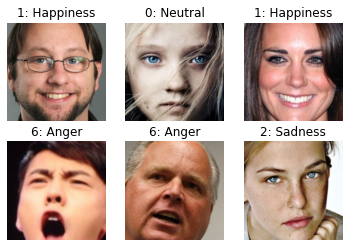

In [32]:
# test if works
train_loader = get_one_loader()
classes = ['0: Neutral', '1: Happiness', 
           '2: Sadness', '3: Surprise', 
           '4: Fear', '5: Disgust', '6: Anger']

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(2, 3, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(classes[labels[0]])

    k += 1
    if k >= 6:
        break

##Helper functions

In [0]:
###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_accuracy(model, data, train=False):
    with torch.no_grad():
        correct = 0
        total = 0
        #for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        for imgs, labels in data: 
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################
            
            
            output = model(imgs)
            
            #select index with maximum prediction score
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]

            del imgs
            del labels
        return correct / total

def plot_training_curve(path):
    import matplotlib.pyplot as plt

    train_losses = np.loadtxt("{}_train_loss.csv".format(path))
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_losses = np.loadtxt("{}_val_loss.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))

    plt.title("Training Curve")

    n = len(train_losses)
    m = len(val_losses)
    # print(n, m)
    plt.plot(range(1, n + 1), train_losses, label="Train")
    plt.plot(range(1, m + 1), val_losses, label="Validation ")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(range(1, n + 1), train_acc, label="Train")
    plt.plot(range(1, m + 1), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    print("Final Training Loss: {}".format(train_losses[-1]))
    print("Final Validation Loss: {}".format(val_losses[-1]))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [0]:
# import torchvision.models
# torchvision.models.inception.inception_v3(pretrained=True)
import torchvision.models

# ***Model Training***

In [0]:
def train(model, batch_size=64, learning_rate=0.01, num_epochs=1):
    train_feature = get_one_loader(PATH_TRAIN,batch_size)
    val_feature = get_one_loader(PATH_VALID,batch_size)
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # print(model.parameters())
    iters, viters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], [], []

    # training
    n = 0 # the number of iterations
    m = 0
    for epoch in range(num_epochs):
        train_loss_tot = 0
        val_loss_tot = 0
        train_item = 0
        val_item = 0
        print("Starting epoch ", epoch)

        for features, labels in iter(train_feature):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(features)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            train_loss_tot += loss
            train_item += 1
            iters.append(n)
            n += 1

        with torch.no_grad():      
          for features, labels in iter(val_feature):
            #############################################
              #To Enable GPU Usage
              if use_cuda and torch.cuda.is_available():
                features = features.cuda()
                labels = labels.cuda()
              #############################################
              
              out = model(features)             # forward pass
              loss = criterion(out, labels) # compute the total loss
              val_loss_tot += loss
              val_item += 1
              viters.append(m)
              m += 1
              
        # save the training info for every few (1) epoches:
        #iters.append(n)
        train_losses.append(float(train_loss_tot)/train_item)             # compute *average* loss
        get_acc = get_accuracy(model, train_feature)
        train_acc.append(get_acc) # compute training accuracy 

        val_losses.append(float(val_loss_tot)/val_item)             # compute *average* loss
        get_acc_val = get_accuracy(model, val_feature)
        val_acc.append(get_acc_val)  # compute validation accuracy

        #print("Iter {}: ".format(n))
        print("Train loss: {}, Train acc: {}".format(float(train_loss_tot)/train_item, get_acc))
        print("Validation loss: {}, Validation acc: {}".format(float(val_loss_tot)/val_item, get_acc_val))
  
        # (checkpoint)
        model_path = get_model_name("FaceRec", batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)  
        # for plotting later (checkpoint)
        np.savetxt("{}_train_loss.csv".format(model_path), train_losses)
        np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
        np.savetxt("{}_val_loss.csv".format(model_path), val_losses)
        np.savetxt("{}_val_acc.csv".format(model_path), val_acc)      
    print("Finished training")

In [0]:
import torchvision.models
googlenet = torchvision.models.googlenet(pretrained=True)
model = googlenet
model.fc = nn.Linear(1024, 7)

In [0]:
# training
use_cuda = True
# model = MyGoogleNet()
if use_cuda and torch.cuda.is_available():
  torch.cuda.empty_cache()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, batch_size=128, learning_rate=0.001, num_epochs=15)

model_path = get_model_name("FaceRec", batch_size=128, learning_rate=0.001, epoch=14)
plot_training_curve(model_path)

CUDA is available!  Training on GPU ...
Starting epoch  0
Train loss: 0.7968197393230096, Train acc: 0.7390303838354537
Validation loss: 1.066932504827326, Validation acc: 0.5866071428571429
Starting epoch  1
Train loss: 0.7057794300584612, Train acc: 0.7533562241815499
Validation loss: 1.0289227745749734, Validation acc: 0.6105357142857143
Starting epoch  2
Train loss: 0.6644672801008569, Train acc: 0.7684156501995744
Validation loss: 1.0489295612681995, Validation acc: 0.6060714285714286
Starting epoch  3
Train loss: 0.6265573225801053, Train acc: 0.7851402877998845
Validation loss: 1.0010787790471858, Validation acc: 0.6267857142857143
Starting epoch  4
Train loss: 0.5885823422438415, Train acc: 0.8015943633843124
Validation loss: 1.0022154721346768, Validation acc: 0.6319642857142858
Starting epoch  5
Train loss: 0.5462252076546322, Train acc: 0.8175826260135616
Validation loss: 1.0621767911044033, Validation acc: 0.6403571428571428
Starting epoch  6
Train loss: 0.5001256003715191,

In [0]:
model = googlenet
model.fc = nn.Linear(1024, 7)
use_cuda = True
if use_cuda and torch.cuda.is_available():
  torch.cuda.empty_cache()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
model_path = get_model_name("FaceRec", batch_size=128, learning_rate=0.001, epoch=6)
state = torch.load(model_path)
model.load_state_dict(state)
model.eval()
def check_acc():
  val_feature = get_one_loader(PATH_VALID,1)
  get_acc_val = get_accuracy(model, val_feature)
  print("Validation accuracy: ", get_acc_val)
check_acc()

with 45w data:

In [0]:
# training
use_cuda = True
# model = MyGoogleNet()
if use_cuda and torch.cuda.is_available():
  torch.cuda.empty_cache()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, batch_size=128, learning_rate=0.001, num_epochs=15)

CUDA is available!  Training on GPU ...
Starting epoch  0
Train loss: 0.7971567074259193, Train acc: 0.7360960411477409
Validation loss: 1.082018418745561, Validation acc: 0.5846428571428571
Starting epoch  1
Train loss: 0.7072988807708185, Train acc: 0.7532558094127688
Validation loss: 1.0487824353304775, Validation acc: 0.6055357142857143
Starting epoch  2
Train loss: 0.6654543891969386, Train acc: 0.7684547003874337
Validation loss: 1.052583174272017, Validation acc: 0.6010714285714286
Starting epoch  3
Train loss: 0.6272711789595233, Train acc: 0.7839213640788479
Validation loss: 1.0314740267666904, Validation acc: 0.6180357142857142
Starting epoch  4
Train loss: 0.5893814430114245, Train acc: 0.8006543695765564
Validation loss: 1.0045715678821912, Validation acc: 0.6392857142857142
Starting epoch  5
Train loss: 0.5474986873410166, Train acc: 0.8203049819671812
Validation loss: 1.0547820871526545, Validation acc: 0.6389285714285714
Starting epoch  6
Train loss: 0.5010021881136202, 

In [0]:
model_path = get_model_name("FaceRec", batch_size=128, learning_rate=0.001, epoch=14)
plot_training_curve(model_path)

In [0]:
from sklearn.metrics import confusion_matrix
batch_size = 64
def plot_confusion_matrix(model, classes,
              normalize=False,
              title=None,
              cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    val_feature = get_one_loader(PATH_VALID,batch_size)
    y_true = []
    y_pred = []
    with torch.no_grad():  
      for features, labels in iter(val_feature):
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          features = features.cuda()
        #############################################
        
          
        out = model(features)             # forward pass
        pred = out.max(1, keepdim=True)[1]
        pred = pred.cpu()
        for predit_num in pred.numpy():
          y_pred.append(predit_num[0])
          #print(predit_num[0])
        for actual_num in labels.numpy():
          y_true.append(actual_num)
          #print(actual_num)
        del features
    # Compute confusion matrix

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = ['','NE','HA','SA','SU','AF','DI','AN']
plot_confusion_matrix(model, classes=class_names,
                      title='Confusion matrix')
plt.savefig('primary_model_confusion_matrix.png')
plt.show()